In [487]:
import torch
from transformers import AutoFeatureExtractor, ASTForAudioClassification
from dataset import CustomDataset


SR = 16000

# Load the dataset
dataset = CustomDataset(datapath='./pre_processed/3_genus/test/data.pt', type='genus')
feature_extractor = AutoFeatureExtractor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")


In [594]:
# Load the trained model
model_path = "/gpfs/proj1/choe_lab/tanu/Genus_classification/saved_model_genus/3_genus/LR1e-5/trial1_BS4_imbalanced_ep10_correct/epoch=0.ckpt"


In [595]:
num_classes = len(dataset.label2id)
label2id=dataset.label2id
id2label=dataset.id2label

In [596]:
print(dataset.label2id)

{'Cycloptilum': 0, 'Gryllus': 1, 'Oecanthus': 2}


In [597]:
model = ASTForAudioClassification.from_pretrained('MIT/ast-finetuned-audioset-10-10-0.4593',label2id=label2id, id2label=id2label ,num_labels=num_classes,ignore_mismatched_sizes=True)

checkpoint = torch.load(model_path)
model_state_dict = checkpoint['state_dict']


Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [599]:
from pytorch_lightning import LightningModule

class ASDF(LightningModule):
    def __init__(self, model):
        super(ASDF, self).__init__()
        self.model = model

In [600]:
light_model = ASDF(model)
light_model.load_state_dict(model_state_dict)

<All keys matched successfully>

In [601]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
light_model.to(device)

def predict(audio_data):
    inputs = feature_extractor(audio_data, sampling_rate=SR, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class_ids = torch.argmax(logits, dim=-1).item()
        # predicted_label = model.config.id2label[predicted_class_ids]

    return predicted_class_ids

# Test the model on a sample from the dataset
sample_idx = 0
waveform, label_id = dataset[sample_idx]
true_label = dataset.id2label[label_id.item()]

predicted_label = predict(waveform)

print(f"True label: {true_label}")
print(f"Predicted label: {predicted_label}")

True label: Cycloptilum
Predicted label: 1


In [602]:
print(dataset.id2label)
label_list = []
for k,v in dataset.id2label.items():
    label_list.append(v)
print(label_list)

{0: 'Cycloptilum', 1: 'Gryllus', 2: 'Oecanthus'}
['Cycloptilum', 'Gryllus', 'Oecanthus']


In [603]:
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

In [604]:
x_data = list()
y_data = list()

for i in range(len(dataset)):
    x_data.append(dataset[i][0].numpy())
    y_data.append(dataset[i][1].numpy())
   
x_test = np.array(x_data)
print(x_test.shape)
y_test = np.array(y_data)
print(y_test.shape)

(227, 160000)
(227,)


In [605]:
count = {}
for i in range(len(dataset)):
    if y_test[i] not in count:
        count[y_test[i]] = 1
    else:
        count[y_test[i]] += 1

count = dict(sorted(count.items()))
print(count)    

{0: 45, 1: 130, 2: 52}


In [606]:
y_pred = list()
for i in tqdm(range(len(dataset))):
    waveform, label_id = dataset[i]
    y_pred_i = predict(waveform)
    y_pred.append(y_pred_i)

100%|█████████████████████████████████████████| 227/227 [00:09<00:00, 23.49it/s]


In [607]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[ 28,  16,   1],
       [  3, 103,  24],
       [  0,   1,  51]])

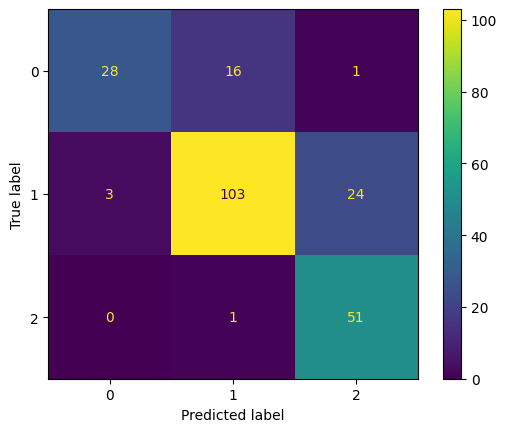

In [608]:
metrics.ConfusionMatrixDisplay(conf_matrix).plot()